In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

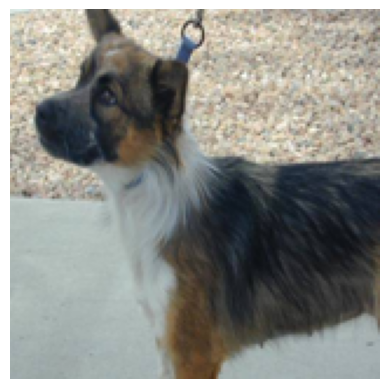

In [103]:
image_path = 'train/dog.3.jpg' 
image = Image.open(image_path)

# Resize the image
resized_image = image.resize((158, 158))

# If the image is not in RGB mode, convert it to RGB
if resized_image.mode != 'RGB':
    resized_image = resized_image.convert('RGB')

# Convert the resized image to a numpy array
image_array = np.array(resized_image)

# Display the resized image
plt.imshow(image_array)
plt.axis('off')
plt.show()


In [102]:
# dogs_num = 12499
# cats_num = 12499
dogs_num = 2000
cats_num = 2000
image_size = (158, 158)
train_dir = 'train'
validation_split = 0.2

# Function to load and process images
def load_image(image_path):
    image = Image.open(image_path)
    resized_image = image.resize(image_size)
    if resized_image.mode != 'RGB':
        resized_image = resized_image.convert('RGB')
    image_array = np.array(resized_image)
    return image_array

# Function to create dataset
def create_dataset(dir_path, dogs_num, cats_num):
    data = []
    labels = []
    
    for i in range(dogs_num):
        image_path = os.path.join(dir_path, f'dog.{i}.jpg')
        image_array = load_image(image_path)
        label = np.array([[1, 0]])  # Dog label
        data.append((image_array, label))
        
    for i in range(cats_num):
        image_path = os.path.join(dir_path, f'cat.{i}.jpg')
        image_array = load_image(image_path)
        label = np.array([[0, 1]])  # Cat label
        data.append((image_array, label))
    
    return data

# Load training data
train_data = create_dataset(train_dir, dogs_num, cats_num)

# Shuffle data
np.random.shuffle(train_data)

# Manually split into training and validation sets
split_index = int(len(train_data) * (1 - validation_split))
train_set = train_data[:split_index]
val_set = train_data[split_index:]

# Example of accessing data
print(f'Training set size: {len(train_set)}')
print(f'Validation set size: {len(val_set)}')

# Example: Access an image and label from the training set
example_image, example_label = train_set[0]
print(f'Example image shape: {example_image.shape}')
print(f'Example label: {example_label}')


Training set size: 3200
Validation set size: 800
Example image shape: (158, 158, 3)
Example label: [[1 0]]


(158, 158, 3)


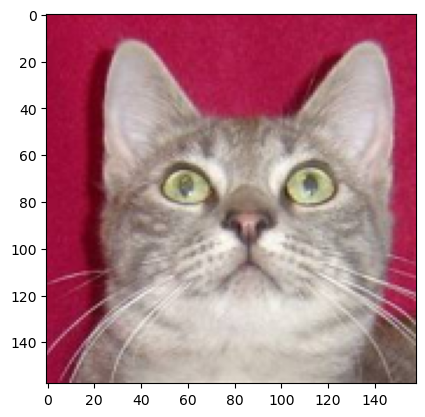

In [104]:
plt.imshow(train_set[4][0])
print(train_set[4][0].shape)

In [105]:
# Setting up functions in forward propogation
# We will forward propogate one piece of data at a time, then average over the examples, to simulate batches
def batch_norm_forward(x, gamma, beta, eps=1e-5):
    mean = np.mean(x, axis=0)
    variance = np.var(x, axis=0) # std_dev ** 2
    x_normalized = (x - mean) / np.sqrt(variance + eps)
    # gamma and beta are learned
    out = gamma * x_normalized + beta
    cache = (x, x_normalized, mean, variance, gamma, beta, eps)
    return out, cache


def batch_norm_backward(dout, cache):
    x, x_normalized, mean, variance, gamma, beta, eps = cache
    N = x.shape[0]
    
    dbeta = np.sum(dout, axis=0)
    dgamma = np.sum(dout * x_normalized, axis=0)
    
    dx_normalized = dout * gamma
    dvariance = np.sum(dx_normalized * (x - mean) * -0.5 * np.power(variance + eps, -1.5), axis=0)
    dmean = np.sum(dx_normalized * -1 / np.sqrt(variance + eps), axis=0) + dvariance * np.sum(-2 * (x - mean), axis=0) / N
    
    dx = dx_normalized / np.sqrt(variance + eps) + dvariance * 2 * (x - mean) / N + dmean / N
    return dx, dgamma, dbeta



def max_pooling(input_data, output_data):
    input_height, input_width, input_depth = input_data.shape

    # Calculate the output dimensions
    output_height = input_height // 2 
    output_width = input_width // 2
    output_depth = input_depth

    # Initialize the output array and array to store indices
    output_data = np.zeros((output_height, output_width, output_depth))
    indices = np.zeros((output_height, output_width, output_depth, 2), dtype=int)

    # Apply max pooling
    for h in range(output_height):
        for w in range(output_width):
            for d in range(output_depth):
                # Extract the 2x2 region of interest from the input data
                region = input_data[h*2:(h+1)*2, w*2:(w+1)*2, d]
                # Compute the maximum value in the region
                max_val = np.max(region)
                output_data[h, w, d] = max_val
                # Find the indices of the maximum value in the region
                max_indices = np.unravel_index(np.argmax(region), region.shape)
                # Store the indices relative to the region and convert to global indices
                indices[h, w, d] = [h*2 + max_indices[0], w*2 + max_indices[1]]

    return output_data, indices


def correlate(input_image, kernel):
    # Dimensions of the input and kernel
    input_height, input_width, input_channels = input_image.shape
    filter_height, filter_width, filter_channels, num_filters = kernel.shape
    
    # Output dimensions
    output_height = input_height - filter_height + 1 # (H - S + 1)
    output_width = input_width - filter_width + 1 # (W - S + 1)

    # Initialize the output
    output = np.zeros((output_height, output_width, num_filters))
    
    # Loop through each filter
    for filter in range(num_filters):
        # Loop through height and width of the output
        for i in range(output_height):
            for j in range(output_width):
                # Extract the patch from the input image
                input_patch = input_image[i:i+filter_height, j:j+filter_width, :]
                # Perform the correlation operation
                output[i, j, filter] = np.sum(input_patch * kernel[:, :, :, filter]) 
    return output


def convolve(input_image, kernel):
    # Dimensions of the input and kernel
    input_height, input_width, input_channels = input_image.shape
    filter_height, filter_width, filter_channels, num_filters = kernel.shape
    
    # Padding size (pad_height and pad_width are half the kernel size, rounded down)
    pad_height = filter_height - 1
    pad_width = filter_width - 1
    
    # Output dimensions
    output_height = input_height + pad_height # 7
    output_width = input_width + pad_width # 7

    # Initialize the output
    output = np.zeros((output_height, output_width, num_filters))
    
    # Pad the input image with zeros
    padded_input = np.pad(input_image, ((pad_height, pad_height), (pad_width, pad_width), (0, 0)), mode='constant')
    
    # Flip kernel horizontally and vertically
    rotated_kernel = np.flip(kernel, axis=(0, 1))
    
    # Loop through each filter
    for filter in range(num_filters):
        # Loop through the height and width of the output
        for i in range(output_height):
            for j in range(output_width):
                # Extract the patch from the padded input image
                input_patch = padded_input[i:i+filter_height, j:j+filter_width, :]
                # Perform the convolution operation
                output[i, j, filter] = np.sum(input_patch * rotated_kernel[:, :, :, filter])
    return output


def der_ReLU(Z):
  return Z > 0

def ReLU2(Z, alpha=0.01):
    return np.where(Z > 0, Z, alpha * Z)

def ReLU(Z): # Takes in a scalar, returns a scalar
    return np.maximum(Z, 0)

def ReLU2(Z): # Takes in a scalar, returns a scalar
    return np.maximum(Z, 0)

def sigmoid_prime(z):
  return sigmoid(z)*(1-sigmoid(z))

def sigmoid(z):
    # Compute the sigmoid function element-wise
    return 1.0 / (1.0 + np.exp(-z))

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    sum_exp_Z = np.sum(exp_Z, axis=1, keepdims=True)
    return exp_Z / sum_exp_Z


In [106]:
# Define parameters
# Convolutional layer -> ReLU activation -> Batch normalization -> Dropout -> Max pooling

# Layer 1
# Input (158, 158, 3)
conv1_kernel = np.random.randn(3, 3, 3, 32)
conv1_bias = np.zeros((156, 156, 32))
layer1_output = np.zeros((156, 156, 32))

gamma1_conv = np.ones((156, 156, 32))
beta1_conv = np.zeros((156, 156, 32))

layer1_pool = np.zeros((78, 78, 32))

# Layer 2
conv2_kernel = np.random.randn(3, 3, 32, 64)
conv2_bias = np.zeros((76, 76, 64))
layer2_output = np.zeros((76, 76, 64))

gamma2_conv = np.ones((76, 76, 64))
beta2_conv = np.zeros((76, 76, 64))

layer2_pool = np.zeros((38, 38, 64))

# Layer 3
conv3_kernel = np.random.randn(3, 3, 64, 128)
conv3_bias = np.zeros((36, 36, 128))
layer3_output = np.zeros((36, 36, 128))

gamma3_conv = np.ones((36, 36, 128))
beta3_conv = np.zeros((36, 36, 128))

layer3_pool = np.zeros((18, 18, 128))

# Layer 6
fc1_weights = np.random.randn(41472, 4096)
fc1_bias = np.zeros((1, 4096))
layer4_1_output = np.zeros((1, 4096))

fc2_weights = np.random.randn(4096, 2)
fc2_bias = np.zeros((1,2))
layer4_2_output = np.zeros((1, 2))

In [107]:
# Forward propogation
# Convolutional layer -> ReLU activation -> Batch normalization -> Dropout -> Max pooling
def forward_propagation(
    layer_input, conv1_kernel, conv1_bias, layer1_output, gamma1_conv, beta1_conv, layer1_pool,
    conv2_kernel, conv2_bias, layer2_output, gamma2_conv, beta2_conv, layer2_pool,
    conv3_kernel, conv3_bias,layer3_output, gamma3_conv,beta3_conv, layer3_pool,
    fc1_weights, fc1_bias, layer6_1_output, fc2_weights, fc2_bias, layer6_2_output, dropout_rate = 0.25):
    print("starting forwardprop")
    
    # Layer 1
    layer1_output = correlate(layer_input, conv1_kernel)
    layer1_output += conv1_bias
    layer1_output = ReLU(layer1_output)

    layer1_output, layer1_cache = batch_norm_forward(layer1_output, gamma1_conv, beta1_conv)
    
    dropout1_mask = (np.random.rand(*layer1_output.shape) < dropout_rate) / dropout_rate   # Matrix of random values between 0 and 1 -> binary 0 and 1 after comparision. We scale by 1 / dropout_rate, so that the CNN's activation after dropout stay relatively the same
    layer1_output *= dropout1_mask

    layer1_pool, layer1_indices = max_pooling(layer1_output, layer1_pool)

    # Layer 2
    layer2_output = correlate(layer1_pool, conv2_kernel)
    layer2_output += conv2_bias
    layer2_output = ReLU(layer2_output)

    layer2_output, layer2_cache = batch_norm_forward(layer2_output, gamma2_conv, beta2_conv)
    
    dropout2_mask = (np.random.rand(*layer2_output.shape) < dropout_rate) / dropout_rate 
    layer2_output *= dropout2_mask

    layer2_pool, layer2_indices = max_pooling(layer2_output, layer2_pool)

    # Layer 3
    layer3_output = correlate(layer2_pool, conv3_kernel)
    layer3_output += conv3_bias
    layer3_output = ReLU(layer3_output)

    layer3_output, layer3_cache = batch_norm_forward(layer3_output, gamma3_conv, beta3_conv)
    
    dropout3_mask = (np.random.rand(*layer3_output.shape) < dropout_rate) / dropout_rate   # Matrix of random values between 0 and 1 -> binary 0 and 1 after comparision. We scale by 1 / dropout_rate, so that the CNN's activation after dropout stay relatively the same
    layer3_output *= dropout3_mask

    layer3_pool, layer3_indices = max_pooling(layer3_output, layer3_pool)
        
    # Layer 4
    layer4_1_output = (layer3_pool.reshape(1, 41472)) @ fc1_weights
    layer4_1_output += fc1_bias

    layer4_1_output = ReLU(layer4_1_output)
    
    layer4_2_output = layer4_1_output @ fc2_weights
    layer4_2_output += fc2_bias
    print(layer4_2_output)
    layer4_2_output = softmax(layer4_2_output)
    print(layer4_2_output)
    
    return (layer1_indices, layer1_cache, dropout1_mask, layer2_indices, layer2_cache, dropout2_mask, layer3_indices, layer3_cache, dropout3_mask)
        

In [108]:
# Backpropogation
# dog = 0, cat = 1. Define first option as dog, second as cat. Can only be [0,1] or [1,0]
# As a tuple, define one training example as a (numpy_array, [1,0]..) tuple
def backward_pass(layer_input, label, layer1_indices, layer1_cache, dropout1_mask, layer2_indices, layer2_cache, dropout2_mask, layer3_indices, layer3_cache, dropout3_mask):
    
    print("starting backprop")   
    
    dlayer3_pool = np.zeros_like(layer3_pool)
    dconv3_kernel = np.zeros_like(conv3_kernel)
    dlayer3_output =np.zeros_like(layer3_output)
    
    dlayer2_pool = np.zeros_like(layer2_pool)
    dconv2_kernel = np.zeros_like(conv2_kernel)
    dlayer2_output = np.zeros_like(layer2_output)

    dlayer1_pool = np.zeros_like(layer1_pool)
    dconv1_kernel = np.zeros_like(conv1_kernel)
    dlayer1_output = np.zeros_like(layer1_output)

    ### Layer 4 ----------------------------------------------------------------------------------------------------------------------------------------
    
    # Softmax
    dlayer4_2_output = layer4_2_output - label # (1,2)
    
    # fc2
    dfc2_bias = dlayer4_2_output 
    
    dfc2_weights = layer4_1_output.T @ dlayer4_2_output # (
    
    dlayer4_1_output = (dlayer4_2_output @ fc2_weights.T) * der_ReLU(layer4_1_output) 
    
    # fc1
    dfc1_bias = dlayer4_1_output
    
    dfc1_weights = (layer3_pool.reshape(1, 41472).T) @ dlayer4_1_output
    
    dlayer3_pool = (dlayer4_1_output @ fc1_weights.T)

    # print(dlayer3_pool.shape)


    ### Layer 3 ----------------------------------------------------------------------------------------------------------------------------------------

    dlayer3_pool = dlayer3_pool.reshape(18, 18, 128)
    
    # print(dlayer3_pool.shape)
    
    # Unpooling
    for i in range(dlayer3_pool.shape[0]):
        for j in range(dlayer3_pool.shape[1]): 
            for k in range(dlayer3_pool.shape[2]):
                # Get the global indices from layer_indices
                x_index, y_index = layer3_indices[i, j, k] # -> (18, 18, 512, 2)
                # Assign the gradient from dZ_pool_output to the corresponding position in dZ_pool_input
                dlayer3_output[x_index, y_index, k] = dlayer3_pool[i, j, k]
    
    # Layer 3 - Dropout
    dlayer3_output *= dropout3_mask

    # Layer 3 - Batch norm
    dlayer3_output, dgamma3_conv, dbeta3_conv = batch_norm_backward(dlayer3_output, layer3_cache)

    # Layer 3 - BP conv
    dlayer3_output *= der_ReLU(layer3_output)
    dconv3_bias = dlayer3_output

    # Looping over filters
    for filter in range(conv3_kernel.shape[3]): 
        temp2 = dlayer3_output[:, :, filter].reshape((dlayer3_output.shape[0], dlayer3_output.shape[0], 1, 1))
        for slice in range(conv3_kernel.shape[2]):
            temp1 = layer2_pool[:, :, slice].reshape((layer2_pool.shape[0], layer2_pool.shape[0], 1))
            dconv3_kernel[:, :, slice, filter] = correlate(temp1, temp2).reshape((3, 3)) # (3,3,256,256)
    print('done31')

    for filter in range(conv3_kernel.shape[3]): 
        temp1 = dlayer3_output[:, :, filter].reshape((dlayer3_output.shape[0], dlayer3_output.shape[0], 1))
        for slice in range(conv3_kernel.shape[2]):
            temp2 = conv3_kernel[:, :, slice, filter].reshape((3, 3, 1, 1))
            dlayer2_pool += convolve(temp1, temp2)
    print('done32')

    ### Layer 2 ----------------------------------------------------------------------------------------------------------------------------------------
    # Unpooling 
    for i in range(dlayer2_pool.shape[0]):
        for j in range(dlayer2_pool.shape[1]): 
            for k in range(dlayer2_pool.shape[2]):
                # Get the global indices from layer_indices
                x_index, y_index = layer2_indices[i, j, k] # -> (18, 18, 512, 2)
                # Assign the gradient from dZ_pool_output to the corresponding position in dZ_pool_input
                dlayer2_output[x_index, y_index, k] = dlayer2_pool[i, j, k]
    
    # Layer 2 - Dropout
    dlayer2_output *= dropout2_mask

    # Layer 2 - Batch norm
    dlayer2_output, dgamma2_conv, dbeta2_conv = batch_norm_backward(dlayer2_output, layer2_cache)

    # Layer 2 - BP conv
    dlayer2_output *= der_ReLU(layer2_output)
    dconv2_bias = dlayer2_output

    # Looping over filters
    for filter in range(conv2_kernel.shape[3]): # 128
        temp2 = dlayer2_output[:, :, filter].reshape((dlayer2_output.shape[0], dlayer2_output.shape[0], 1, 1))
        for slice in range(conv2_kernel.shape[2]): # 128
            temp1 = layer1_pool[:, :, slice].reshape((layer1_pool.shape[0], layer1_pool.shape[0], 1))
            dconv2_kernel[:, :, slice, filter] = correlate(temp1, temp2).reshape((3, 3)) # (3,3,128,128)
    print('done21')

    for filter in range(conv2_kernel.shape[3]): 
        temp1 = dlayer2_output[:, :, filter].reshape((dlayer2_output.shape[0], dlayer2_output.shape[0], 1))
        for slice in range(conv2_kernel.shape[2]): 
            temp2 = conv2_kernel[:, :, slice, filter].reshape((3, 3, 1, 1))
            dlayer1_pool += convolve(temp1, temp2)
    print('done22')
    

    ### Layer 1 ----------------------------------------------------------------------------------------------------------------------------------------
    
    # Unpooling
    for i in range(dlayer1_pool.shape[0]):
        for j in range(dlayer1_pool.shape[1]): 
            for k in range(dlayer1_pool.shape[2]):
                # Get the global indices from layer_indices
                x_index, y_index = layer1_indices[i, j, k] # -> (18, 18, 512, 2)
                # Assign the gradient from dZ_pool_output to the corresponding position in dZ_pool_input
                dlayer1_output[x_index, y_index, k] = dlayer1_pool[i, j, k]
    
    # Layer 1 - Dropout
    dlayer1_output *= dropout1_mask
    
    # Layer 1 - Batch norm
    dlayer1_output, dgamma1_conv, dbeta1_conv = batch_norm_backward(dlayer1_output, layer1_cache)

    # Layer 1 - BP conv2
    dlayer1_output *= der_ReLU(layer1_output) # (144,144,64)
    dconv1_bias = dlayer1_output # (144,144,64)

    # Looping over filters
    for filter in range(conv1_kernel.shape[3]): # 64
        temp2 = dlayer1_output[:, :, filter].reshape((dlayer1_output.shape[0], dlayer1_output.shape[0], 1, 1))
        for slice in range(layer_input.shape[2]): # 3
            temp1 = layer_input[:, :, slice].reshape((layer_input.shape[0], layer_input.shape[0], 1))
            dconv1_kernel[:, :, slice, filter] = correlate(temp1, temp2).reshape((3, 3)) # (3,3,3,64)
    print('done11')
    
    print('no backprop into input :)')

    return (dconv1_kernel, dconv1_bias, dgamma1_conv, dbeta1_conv,
    dconv2_kernel, dconv2_bias, dgamma2_conv, dbeta2_conv, 
    dconv3_kernel, dconv3_bias, dgamma3_conv, dbeta3_conv,
    dfc1_weights, dfc1_bias, dfc2_weights, dfc2_bias)

In [89]:
# backward_pass(train_set[4][0], train_set[4][1], layer1_indices, layer1_cache, dropout1_mask, layer2_indices, layer2_cache, dropout2_mask, layer3_indices, layer3_cache, dropout3_mask)

In [109]:
def update_params(
    dconv1_kernel, dconv1_bias, dgamma1_conv, dbeta1_conv,
    dconv2_kernel, dconv2_bias, dgamma2_conv, dbeta2_conv, 
    dconv3_kernel, dconv3_bias, dgamma3_conv, dbeta3_conv,
    dfc1_weights, dfc1_bias, dfc2_weights, dfc2_bias,
    learning_rate
):
    conv1_kernel -= learning_rate * dconv1_kernel
    conv1_bias -= learning_rate * dconv1_bias
    gamma1_conv -= learning_rate * dgamma1_conv
    beta1_conv -= learning_rate * dbeta1_conv

    conv2_kernel -= learning_rate * dconv2_kernel
    conv2_bias -= learning_rate * dconv2_bias
    gamma2_conv -= learning_rate * dgamma2_conv
    beta2_conv -= learning_rate * dbeta2_conv

    conv3_kernel -= learning_rate * dconv3_kernel
    conv3_bias -= learning_rate * dconv3_bias
    gamma3_conv -= learning_rate * dgamma3_conv
    beta3_conv -= learning_rate * dbeta3_conv

    fc1_weights -= learning_rate * dfc1_weights
    fc1_bias -= learning_rate * dfc1_bias
    fc2_weights -= learning_rate * dfc2_weights
    fc2_bias -= learning_rate * dfc2_bias

In [85]:
def get_prediction(output):
    return np.argmax(output, axis=1)

In [116]:
def stochastic_gradient_descent(train_set, val_set, epochs, learning_rate, batch_size):
    num_examples = len(train_set)
    
    for epoch in range(epochs):
        print("Epoch:", epoch + 1)
        
        for batch_start in range(0, num_examples, batch_size):
            batch_end = min(batch_start + batch_size, num_examples)
            
            # Initialize batch_gradients to accumulate gradients
            batch_gradients = [
                np.zeros_like(conv1_kernel), np.zeros_like(conv1_bias),
                np.zeros_like(gamma1_conv), np.zeros_like(beta1_conv),
                
                np.zeros_like(conv2_kernel), np.zeros_like(conv2_bias),
                np.zeros_like(gamma2_conv), np.zeros_like(beta2_conv),
                
                np.zeros_like(conv3_kernel), np.zeros_like(conv3_bias),
                np.zeros_like(gamma3_conv), np.zeros_like(beta3_conv),
                
                np.zeros_like(fc1_weights), np.zeros_like(fc1_bias),
                np.zeros_like(fc2_weights), np.zeros_like(fc2_bias)
            ]
        
            for j in range(batch_start, batch_end):
                # Get a single training example
                layer_input, label = train_set[j]
                
                # Forward propagation
                (layer1_indices, layer1_cache, dropout1_mask, layer2_indices, layer2_cache, dropout2_mask, layer3_indices, layer3_cache, dropout3_mask) = forward_propagation(layer_input, conv1_kernel, conv1_bias, layer1_output, gamma1_conv, beta1_conv, layer1_pool,
                conv2_kernel, conv2_bias, layer2_output, gamma2_conv, beta2_conv, layer2_pool,
                conv3_kernel, conv3_bias, layer3_output, gamma3_conv, beta3_conv, layer3_pool,
                fc1_weights, fc1_bias, layer4_1_output, fc2_weights, fc2_bias, layer4_2_output, 0.25)
                
                # Back propagation
                gradients = backward_pass(layer_input, label, layer1_indices, layer1_cache, dropout1_mask, layer2_indices, layer2_cache, dropout2_mask, layer3_indices, layer3_cache, dropout3_mask)
                # Accumulate gradients
                for k in range(len(batch_gradients)):
                    batch_gradients[k] += gradients[k]
            
            # Average gradients after processing the batch
            batch_gradients = [grad / batch_size for grad in batch_gradients]
            
            # Update parameters after processing the batch
            update_params(*batch_gradients, learning_rate)

        # Get training accuracy
        train_accuracy = 0
        for _ in range(100):
            random_idx = np.random.randint(len(train_set))
            test_input, true_label = train_set[random_idx]
            (layer1_indices, layer1_cache, dropout1_mask, layer2_indices, layer2_cache, dropout2_mask, layer3_indices, layer3_cache, dropout3_mask) = forward_propagation(test_input, conv1_kernel, conv1_bias, layer1_output, gamma1_conv, beta1_conv, layer1_pool,
            conv2_kernel, conv2_bias, layer2_output, gamma2_conv, beta2_conv, layer2_pool,
            conv3_kernel, conv3_bias, layer3_output, gamma3_conv, beta3_conv, layer3_pool,
            fc1_weights, fc1_bias, layer4_1_output, fc2_weights, fc2_bias, layer4_2_output, 0.25)
            prediction = get_prediction(layer4_2_output)
            if np.argmax(true_label) == np.argmax(prediction):
                train_accuracy += 1
        print("Training Accuracy:", train_accuracy / 100)
        
        # Get validation accuracy
        val_accuracy = 0
        for _ in range(100):
            random_idx = np.random.randint(len(val_set))
            test_input, true_label = val_set[random_idx]
            (layer1_indices, layer1_cache, dropout1_mask, layer2_indices, layer2_cache, dropout2_mask, layer3_indices, layer3_cache, dropout3_mask) = forward_propagation(test_input, conv1_kernel, conv1_bias, layer1_output, gamma1_conv, beta1_conv, layer1_pool,
            conv2_kernel, conv2_bias, layer2_output, gamma2_conv, beta2_conv, layer2_pool,
            conv3_kernel, conv3_bias, layer3_output, gamma3_conv, beta3_conv, layer3_pool,
            fc1_weights, fc1_bias, layer4_1_output, fc2_weights, fc2_bias, layer4_2_output, 0.25)
            prediction = get_prediction(layer4_2_output)
            if np.argmax(true_label) == np.argmax(prediction):
                val_accuracy += 1
        print("Validation Accuracy:", val_accuracy / 100)

In [117]:
learning_rate = 0.01
batch_size = 2
epochs = 10
stochastic_gradient_descent(train_set, val_set, epochs, learning_rate, batch_size)

Epoch: 1
starting forwardprop
[[-49035.12507496  -6010.33046479]]
[[0. 1.]]
starting backprop
done31
done32
done21
done22
done11
no backprop into input :)
starting forwardprop
[[-8787.89547416 33994.48225406]]
[[0. 1.]]
starting backprop
done31
done32
done21
done22
done11
no backprop into input :)


UnboundLocalError: cannot access local variable 'conv1_kernel' where it is not associated with a value